<a href="https://colab.research.google.com/github/JohnSmith69969/ADS2002-Monash-Solar-Group/blob/main/Solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the re
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

# Loading data

In [2]:
test = convert_tsf_to_dataframe("/content/drive/MyDrive/Solar Farm Data/phase_2_data.tsf")
test

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Solar Farm Data/phase_2_data.tsf'

In [5]:
train = convert_tsf_to_dataframe("/content/drive/MyDrive/Solar Farm Data/nov_data.tsf")
train

(   series_name     start_timestamp  \
 0    Building0 2016-07-03 21:30:00   
 1    Building1 2019-01-09 23:15:00   
 2    Building3 2016-03-01 04:15:00   
 3    Building4 2019-07-03 04:45:00   
 4    Building5 2019-07-25 23:00:00   
 5    Building6 2019-07-25 01:45:00   
 6       Solar0 2020-04-25 14:00:00   
 7       Solar1 2018-12-31 13:00:00   
 8       Solar2 2019-06-05 14:00:00   
 9       Solar3 2019-06-05 14:00:00   
 10      Solar4 2019-06-05 14:00:00   
 11      Solar5 2019-01-15 13:00:00   
 
                                          series_value  
 0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
 1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
 2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
 3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
 4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
 5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
 6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
 7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

# Data cleaning

# EDA

# Multilinear regression

# Random forest

In [72]:
nov_test = train.explode('series_value')
nov_test

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,606.0
0,Building0,2016-07-03 21:30:00,606.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,9.86
11,Solar5,2019-01-15 13:00:00,6.22
11,Solar5,2019-01-15 13:00:00,7.14
11,Solar5,2019-01-15 13:00:00,5.64


In [73]:
solar_0_test = nov_test.loc[nov_test['series_name']=='Solar0']
solar_1_test = nov_test.loc[nov_test['series_name']=='Solar1']
solar_2_test = nov_test.loc[nov_test['series_name']=='Solar2']
solar_3_test = nov_test.loc[nov_test['series_name']=='Solar3']
solar_4_test = nov_test.loc[nov_test['series_name']=='Solar4']
solar_5_test = nov_test.loc[nov_test['series_name']=='Solar5']

In [75]:
def convert_for_test_data(start_date_str,solar):
    
    end_date_str = '30/11/2020 23:45:00'
# Convert start and end date strings to datetime objects
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
    datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')
    solar['start_timestamp']=datetime_column
    
    #Change column names and the types of variables
    solar = solar.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
    solar = solar[solar.power_output != "NaN"]
    solar["power_output"] = pd.to_numeric(solar["power_output"])
    
    #Increment by 10 hours given the offset of 10 
    solar['timestamp'] = solar['timestamp'] + pd.Timedelta(hours=10)
    
    #index timestamp and sort the time for testing dataset
    solar = solar.set_index(pd.DatetimeIndex(solar['timestamp'])).drop(solar.columns[1], axis=1)
    solar = pd.merge(solar, weather, left_index=True, right_index=True)
    solar = solar[pd.Timestamp('2020-11-01 10:00:00'):pd.Timestamp('2020-12-01 09:45:00')]
    return solar

__Train data__------------------------------------

- Since Solar_0 starts on 25th April 2020, and there's no huge gap, we keep the original solar0 dataset for training. 
- We chose 1st Oct 2019 to be our starting timestamp for each solar because there is very huge gap in power_output prior to 1st Oct 2019 for solar 1 to solar 5

In [76]:
solar1 = solar1[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [77]:
solar2 = solar2[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [78]:
solar3 = solar3[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [79]:
solar4 = solar4[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

In [80]:
solar5 = solar5[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]

#### Test data ------------------------------------------

In [81]:
solar_0_test = convert_for_test_data("2020-04-25 14:00:00",solar_0_test)
solar_1_test = convert_for_test_data("2018-12-31 13:00:00",solar_1_test)
solar_2_test = convert_for_test_data("2019-06-05 14:00:00",solar_2_test)
solar_3_test = convert_for_test_data("2019-06-05 14:00:00",solar_3_test)
solar_4_test = convert_for_test_data("2019-06-05 14:00:00",solar_4_test)
solar_5_test = convert_for_test_data("2019-01-15 13:00:00",solar_5_test)

C:\Users\LOCSEN~1\AppData\Local\Temp/ipykernel_16008/1417913438.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar['start_timestamp']=datetime_column


### Building function for modelling

In [83]:
def reg_model(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    
    X_train = solar_train.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    X_test = solar_test.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return results

In [84]:
def reg_predicted(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    
    X_train = solar_train.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    X_test = solar_test.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return testing_predictions

In [85]:
def compare_1(model,solar,solar_test):
    lin_solar_pred = reg_predicted(model,solar,solar_test)
    d5 = {'Predicted': lin_solar_pred, 'Actual': solar_test['power_output']}
    df5 = pd.DataFrame(data=d5)
    df5 = df5.reset_index(0)
    df5 = df5.replace(df5['Predicted'].loc[df5['Predicted']<0].values[:],0)
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.plot(df5['Actual'],df5['Predicted'],'r.')
    plt.plot(df5['Actual'],df5['Actual'])
    plt.title('Comparison between Predicted and Actual power_output')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.scatter(df5['timestamp'],df5['Predicted'], color='red',label="Predicted")
    #plt.scatter(df5['timestamp'],df5['Actual'], color='blue',label="Actual")
    #plt.legend()
    #plt.tick_params(axis='x', labelrotation = 45)
    plt.show()

In [100]:
from sklearn.ensemble import RandomForestRegressor

#Create a base regression model using the RandomForestRegressor
random_f_solar0 = reg_model(RandomForestRegressor(random_state=0),solar0,solar_0_test)
random_f_solar0

,R^2,RMSE,MAE
train,0.989930,1.004753,0.450621
test,0.784815,7.541011,4.408371


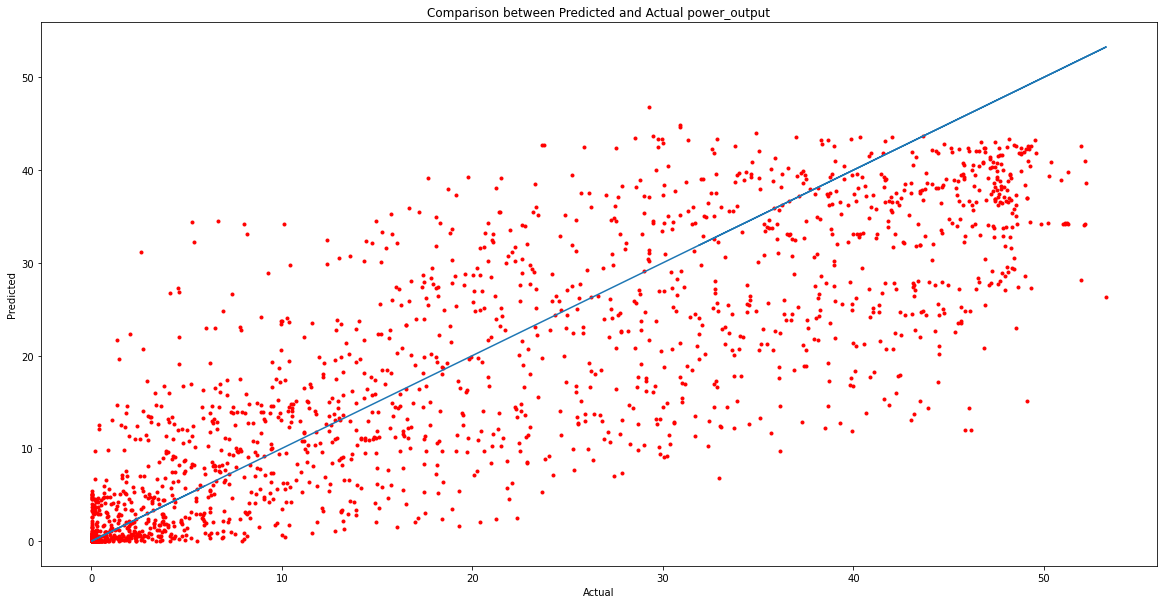

In [101]:
ran_0 = compare_1(RandomForestRegressor(random_state=0),solar0,solar_0_test)
ran_0

In [102]:
#solar11 = solar1.loc[pd.Timestamp('2019-10-01 00:00:00'):pd.Timestamp('2020-11-01 09:45:00')]
#solar11

In [103]:
random_f_solar1 = reg_model(RandomForestRegressor(random_state=0),solar1,solar_1_test)
random_f_solar1

,R^2,RMSE,MAE
train,0.989271,0.392334,0.220841
test,0.834788,1.735052,1.171144


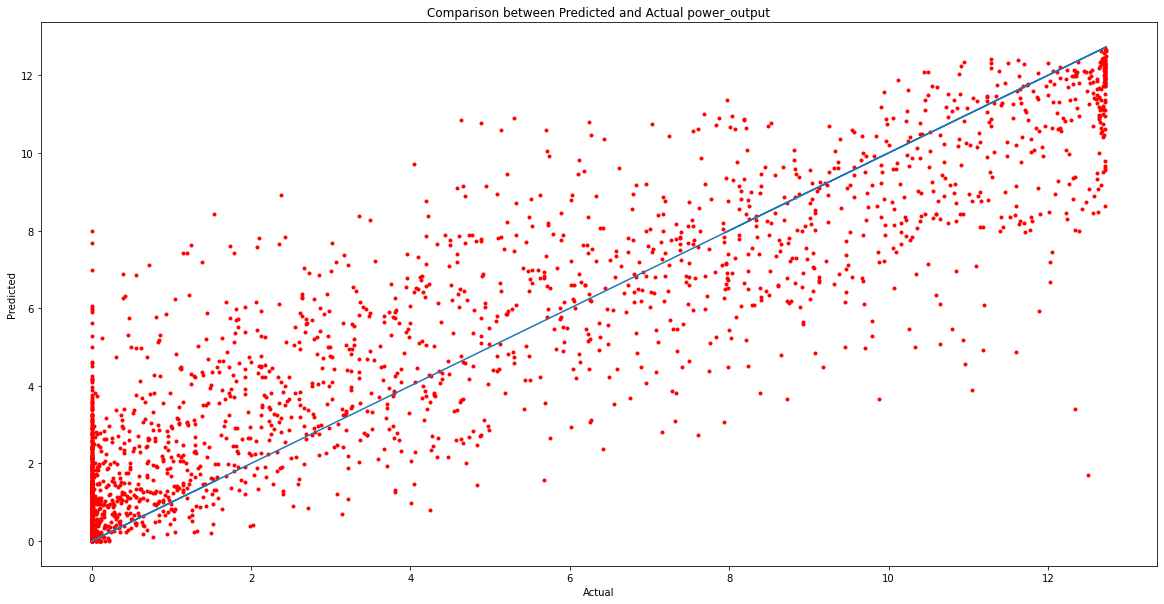

In [104]:
ran_1 = compare_1(RandomForestRegressor(random_state=0),solar1,solar_1_test)
ran_1

In [105]:
random_f_solar2 = reg_model(RandomForestRegressor(random_state=0),solar2,solar_2_test)
random_f_solar2

,R^2,RMSE,MAE
train,0.990893,0.323366,0.178345
test,0.859657,1.595570,0.984584


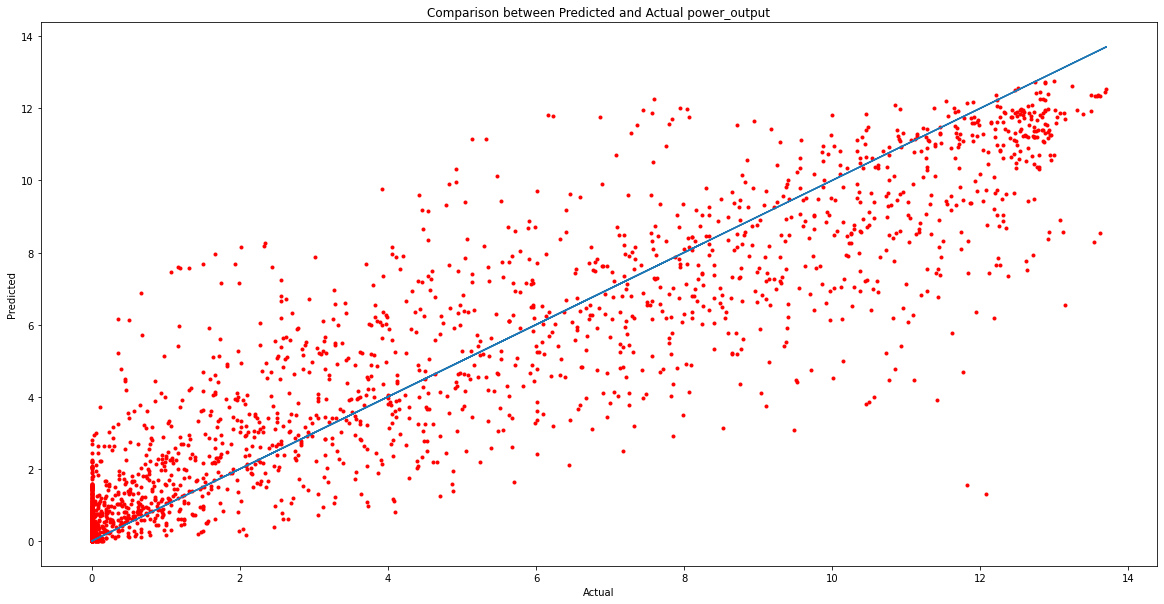

In [106]:
ran_2 = compare_1(RandomForestRegressor(random_state=0),solar2,solar_2_test)
ran_2

In [107]:
random_f_solar3 = reg_model(RandomForestRegressor(random_state=0),solar3,solar_3_test)
random_f_solar3

,R^2,RMSE,MAE
train,0.988719,0.261621,0.131213
test,0.729625,1.982997,1.282667


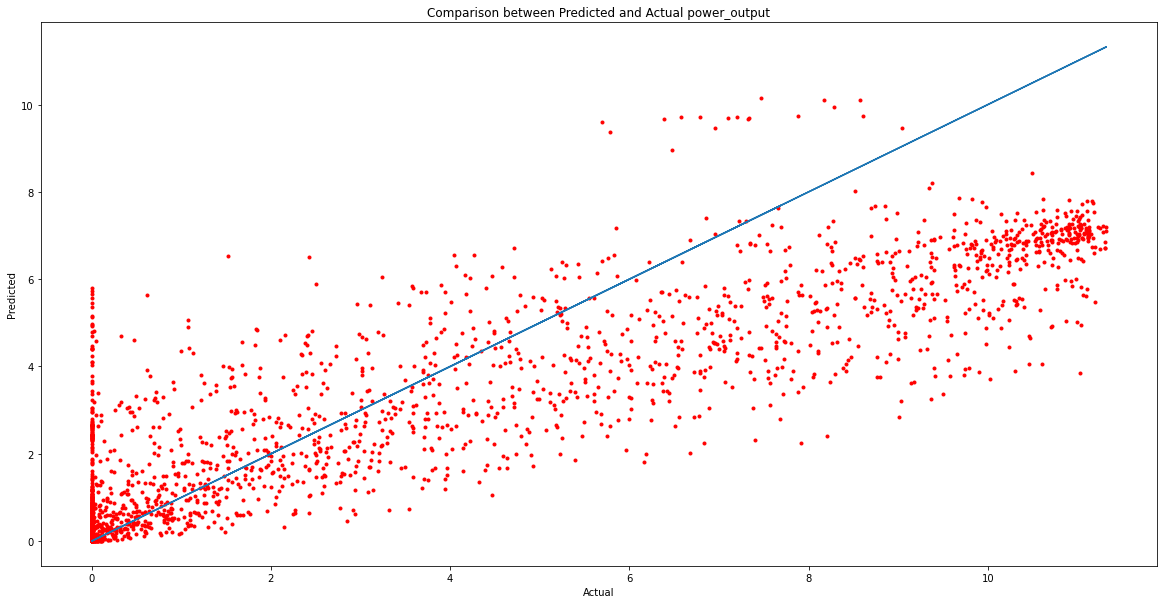

In [108]:
ran_3 = compare_1(RandomForestRegressor(random_state=0),solar3,solar_3_test)
ran_3

In [109]:
random_f_solar4 = reg_model(RandomForestRegressor(random_state=0),solar4,solar_4_test)
random_f_solar4

,R^2,RMSE,MAE
train,0.991311,0.190242,0.102831
test,0.856935,0.955555,0.597376


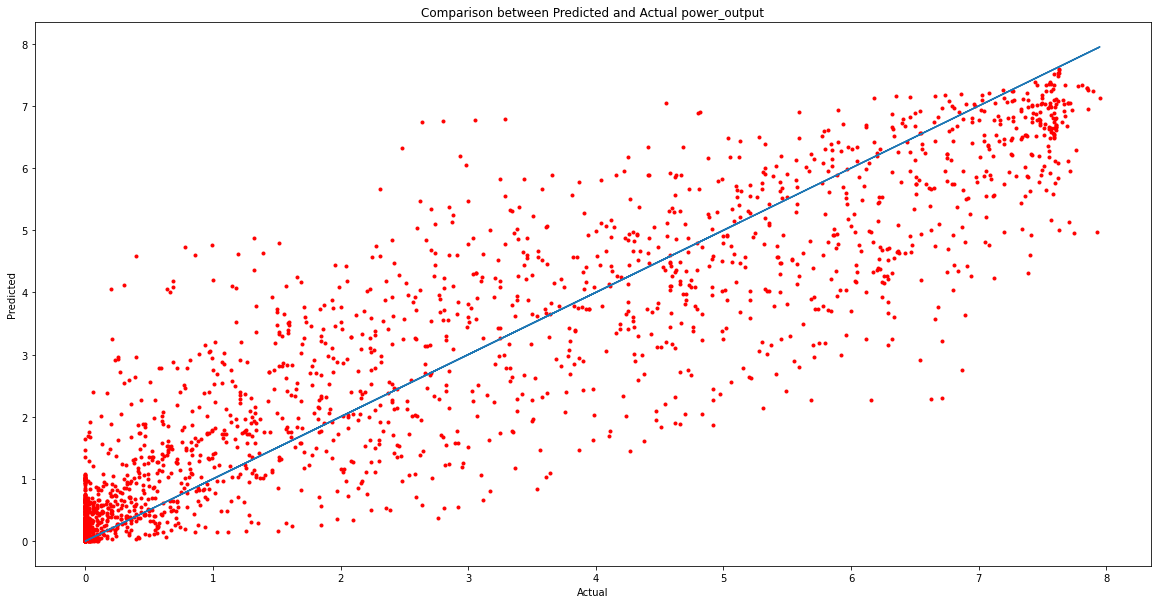

In [110]:
ran_4 = compare_1(RandomForestRegressor(random_state=0),solar4,solar_4_test)
ran_4

In [111]:
random_f_solar5 = reg_model(RandomForestRegressor(random_state=0),solar5,solar_5_test)
random_f_solar5

,R^2,RMSE,MAE
train,0.990468,1.040273,0.513375
test,0.855472,4.889772,2.716174


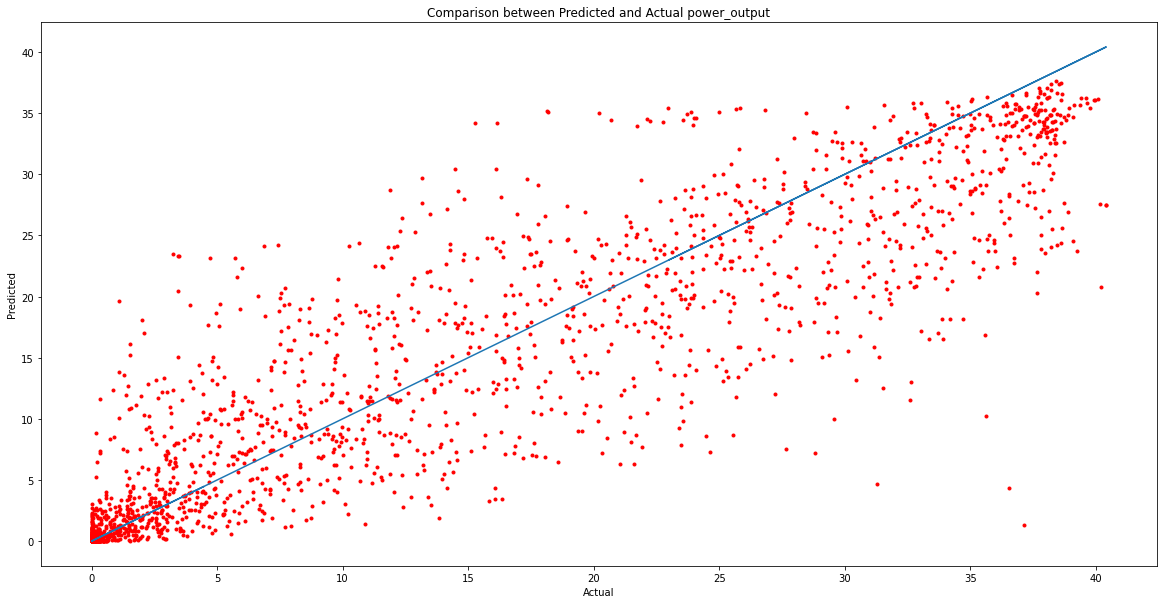

In [112]:
ran_5 = compare_1(RandomForestRegressor(),solar5,solar_5_test)
ran_5

## Feature selection

In [159]:
def feature_select(solar_train, solar_test):
    '''Selecting features'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2, f_regression
    
    X_train = solar_train.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    X_test = solar_test.drop(['solar_no',"power_output","utc_offset (hrs)","model elevation (surface)"],axis=1)
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    features_new = SelectKBest(f_regression, k = "all")
    features_new.fit(X_train, Y_train)
    #pipe.get_feature_names_out()
    df_scores = pd.DataFrame(features_new.scores_)
    df_columns = pd.DataFrame(X_train.columns)
    # concatenate dataframes
    anova_scores = pd.concat([df_columns, df_scores],axis=1)
    anova_scores.columns = ['Feature_Name','Score']  # name output columns

    anova_scores.set_index('Feature_Name', inplace=True)
    anova_scores.sort_values(by='Score').plot(kind='barh', figsize=(8, 7)) # plot these as a bar plot

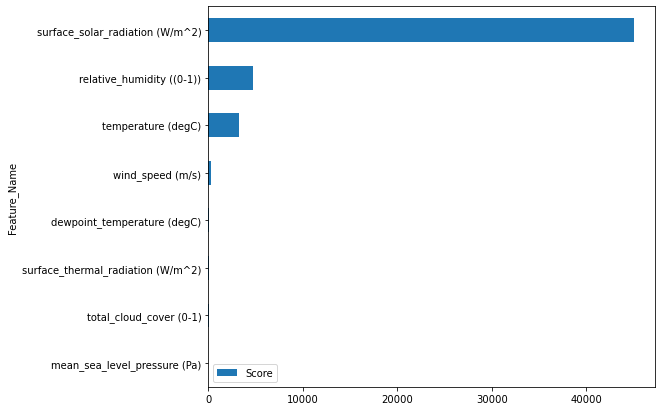

In [160]:
fea_solar_0 = feature_select(solar0,solar_0_test)
fea_solar_0

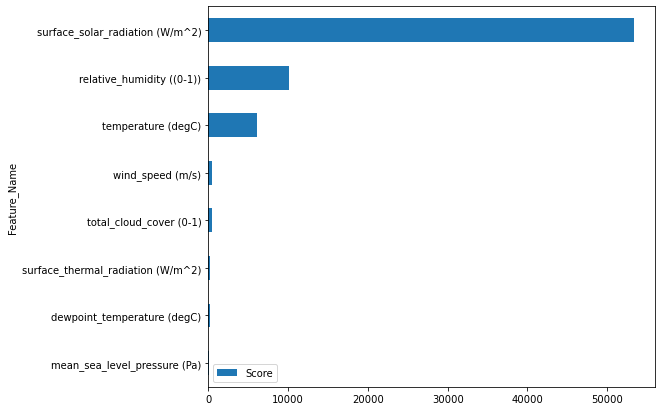

In [161]:
fea_solar_1 = feature_select(solar1,solar_1_test)
fea_solar_1

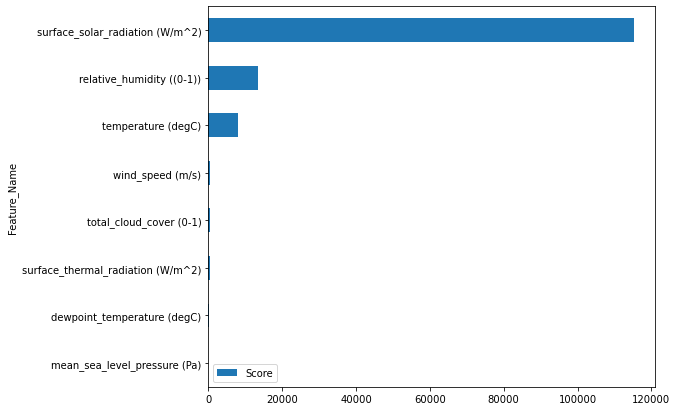

In [162]:
fea_solar_2 = feature_select(solar2,solar_2_test)
fea_solar_2

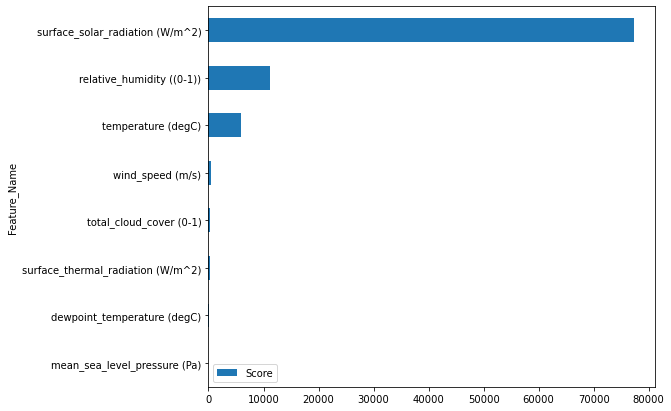

In [163]:
fea_solar_3 = feature_select(solar3,solar_3_test)
fea_solar_3

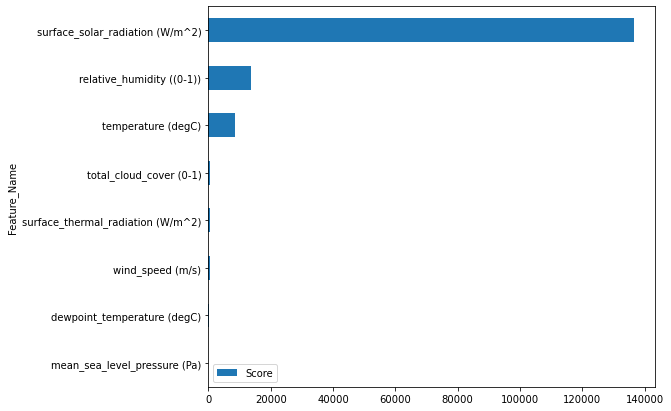

In [164]:
fea_solar_4 = feature_select(solar4,solar_4_test)
fea_solar_4

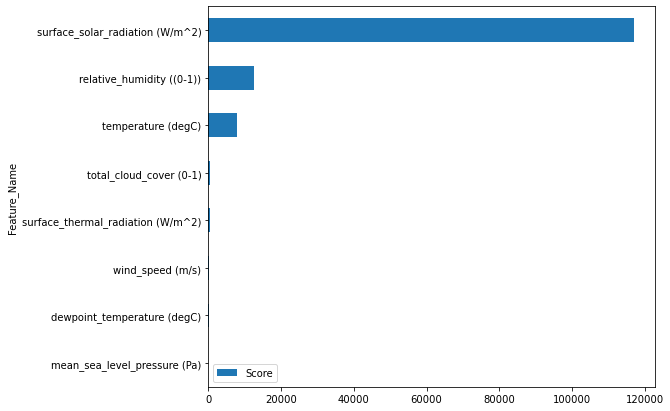

In [165]:
fea_solar_5 = feature_select(solar5,solar_5_test)
fea_solar_5

In [150]:
def new_reg_model(model, solar_train, solar_test):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    
    X_train = solar_train[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    X_test = solar_test[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

# Create a table of the various scores.
    results = pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return results

In [151]:
def new_reg_predicted(model, solar_train, solar_test):
    '''Output predictions'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
    import seaborn as sns
    
    X_train = solar_train[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    X_test = solar_test[['surface_solar_radiation (W/m^2)','relative_humidity ((0-1))','temperature (degC)']]
    Y_train = solar_train['power_output']
    Y_test = solar_test['power_output']
    
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, Y_train)  # apply scaling on training data

    training_predictions = pipe.predict(X_train)  # Get model predictions for both.
    testing_predictions = pipe.predict(X_test)    # training and testing data.

    return testing_predictions

In [152]:
def compare(model,solar,solar_test):
    lin_solar_pred_old = reg_predicted(model,solar,solar_test)
    d = {'Predicted': lin_solar_pred_old, 'Actual': solar_test['power_output']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    df = df.replace(df['Predicted'].loc[df['Predicted']<0].values[:],0)
    
    
    lin_solar_pred = new_reg_predicted(model,solar,solar_test)
    d5 = {'Predicted': lin_solar_pred, 'Actual': solar_test['power_output']}
    df5 = pd.DataFrame(data=d5)
    df5 = df5.reset_index(0)
    df5 = df5.replace(df5['Predicted'].loc[df5['Predicted']<0].values[:],0)
    
    
    #df = df.loc[df['timestamp']>"2020-11-15 00:00:00"]
    #df5 = df5.loc[df5['timestamp']>"2020-11-15 00:00:00"]

    
    
    plt.rcParams["figure.figsize"] = [20, 10]
    #plt.plot(df['timestamp'],df['Predicted'], color='green',label="Predicted_all_features")
    #plt.plot(df5['timestamp'],df5['Predicted'], color='red',label="Predicted_selected_features")
    #plt.plot(df5['timestamp'],df5['Actual'], color='blue',label="Actual")

    plt.plot(df5['Actual'],df['Predicted'],'r.',label="Predicted_all_features")
    plt.plot(df5['Actual'],df5['Predicted'],'r.', color='green',label="Predicted_selected_features")
    plt.plot(df5['Actual'],df5['Actual'], color='blue',label="Identity line")
    
    plt.legend()
    plt.title('Comparison between Predicted power_output of 2 RandomForest models')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.tick_params(axis='x', labelrotation = 45)
    plt.show()

color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.


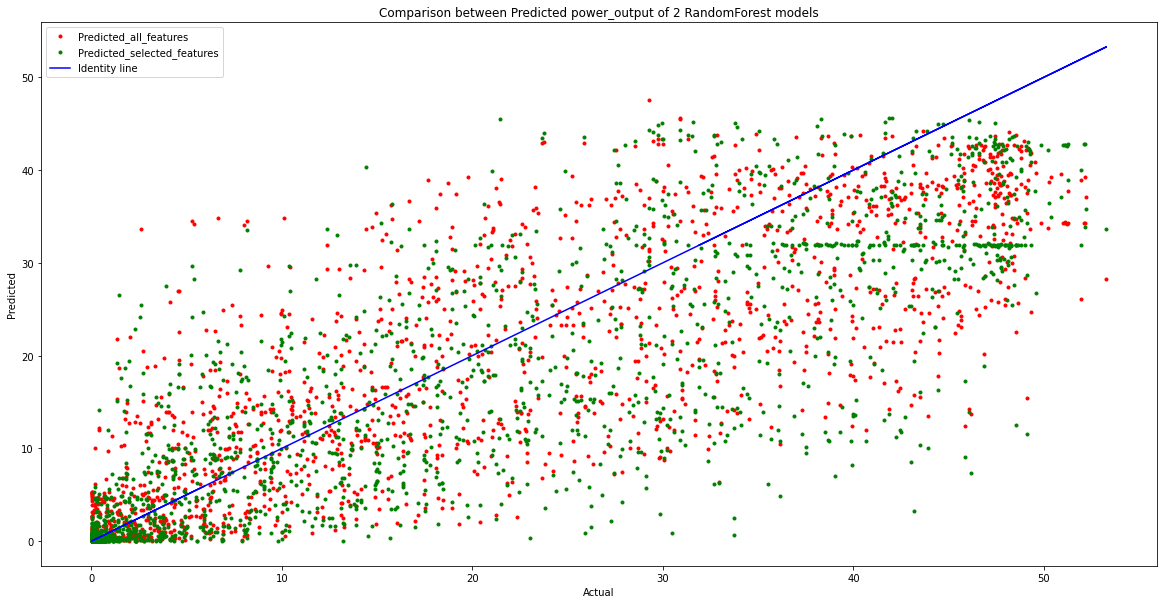

In [153]:
new_ran_0 = compare(RandomForestRegressor(),solar0,solar_0_test)
new_ran_0

color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.


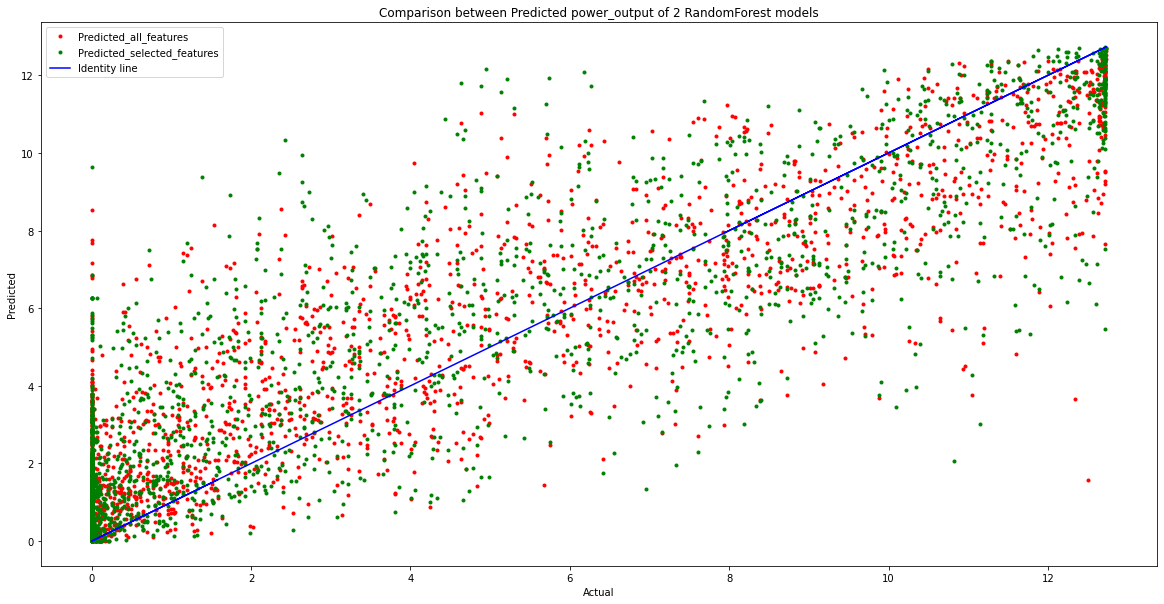

In [154]:
new_ran_1 = compare(RandomForestRegressor(),solar1,solar_1_test)
new_ran_1

color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.


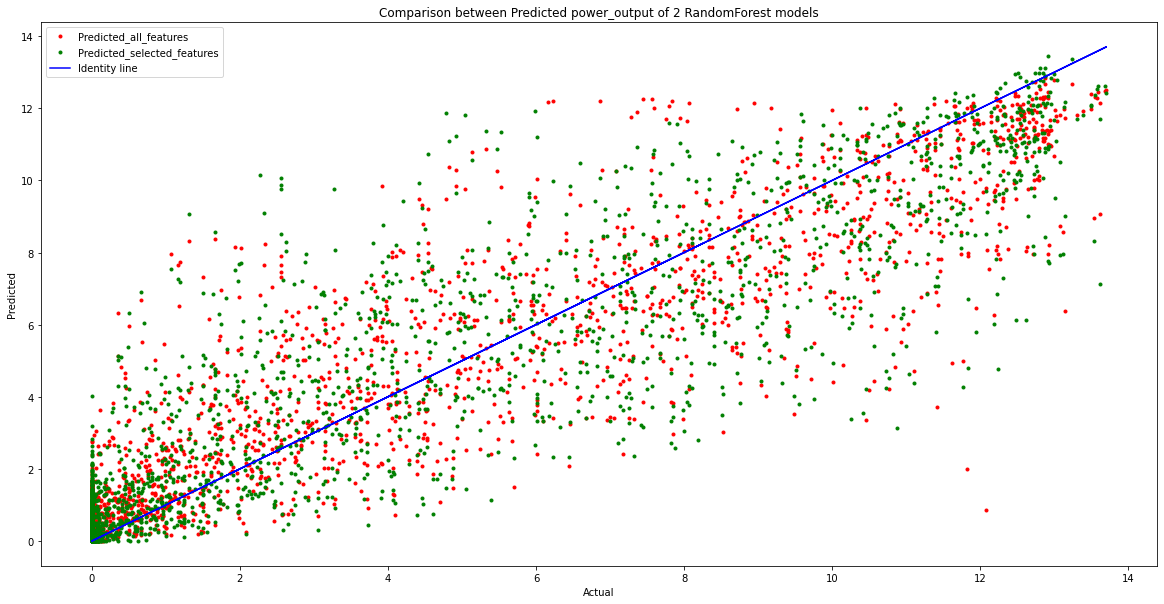

In [155]:
new_ran_2 = compare(RandomForestRegressor(),solar2,solar_2_test)
new_ran_2

color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.


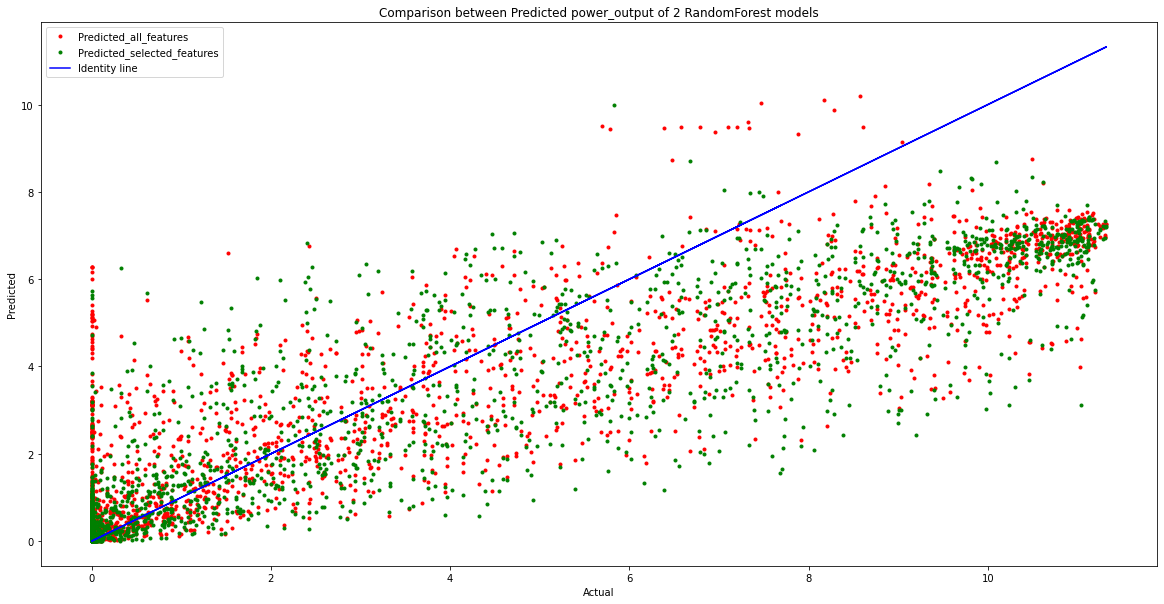

In [156]:
new_ran_3 = compare(RandomForestRegressor(),solar3,solar_3_test)
new_ran_3

color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.


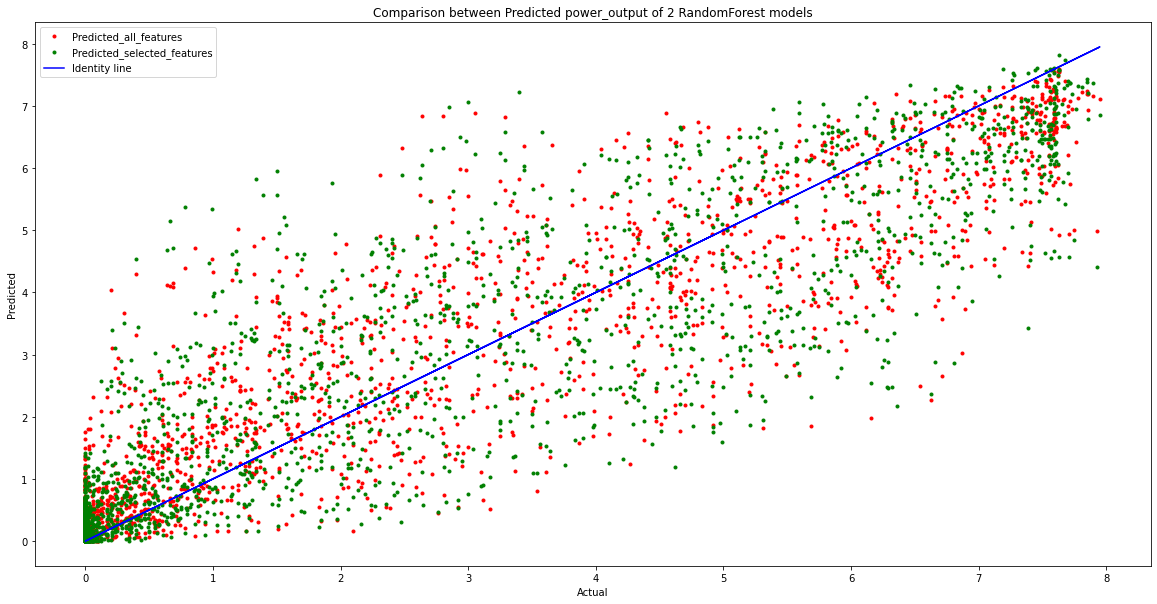

In [157]:
new_ran_4 = compare(RandomForestRegressor(),solar4,solar_4_test)
new_ran_4

color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.


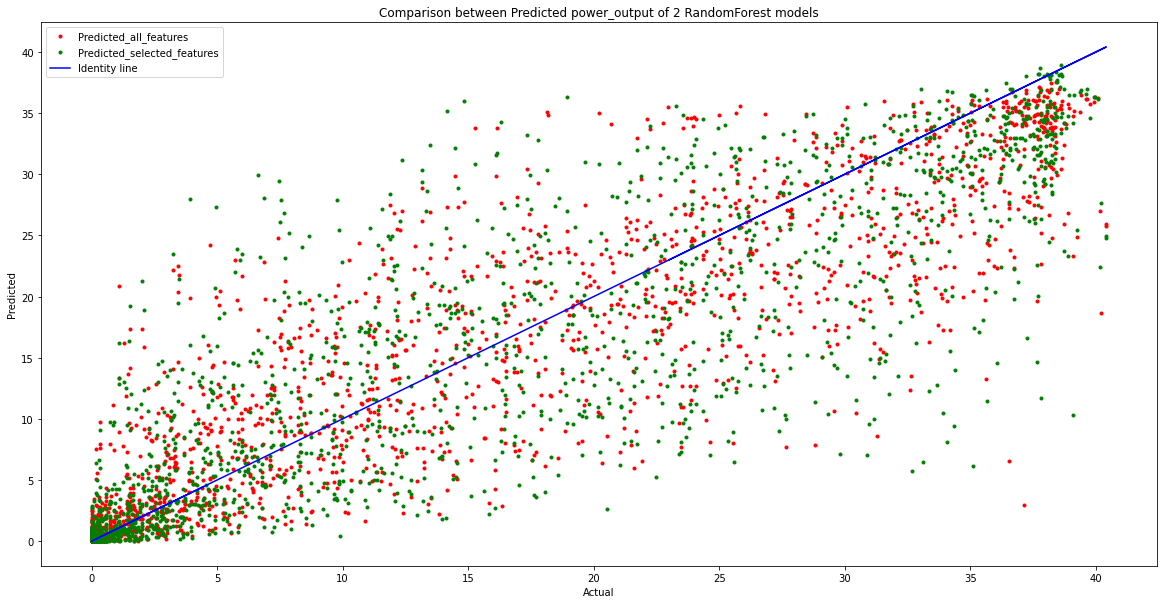

In [158]:
new_ran_5 = compare(RandomForestRegressor(),solar5,solar_5_test)
new_ran_5